In [1]:
import json
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import tifffile
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, Normalize, RandomCrop, Compose
from kmeans_pytorch import kmeans

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import multiplex_imaging_pipeline.utils as utils
from vit_pytorch import ViT, MAE
from vit_pytorch.slide_mae import SlideMAE, SlideMAEV2


In [5]:
metadata = json.load(open('../data/test_registration/HT397B1_v2/registered/metadata.json'))
metadata

{'downsample_scaler': 0.1,
 'phenocycler_pixels_per_micron': 1.9604911906033102,
 'order': ['HT397B1-S1H3A1U1',
  'HT397B1-S1H3A1U2',
  'HT397B1-S1H3A1U12',
  'HT397B1-S1H3A1U21',
  'HT397B1-S1H3A1U22',
  'HT397B1-S1H3A1U31'],
 'data_type': ['visium', 'codex', 'codex', 'visium', 'codex', 'codex'],
 'slices': ['s0', 's1', 's2', 's3', 's4', 's5']}

In [6]:
fps = sorted(utils.listfiles('/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered',
                     regex='ome.tiff$'))
fps

['/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s1.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s2.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s4.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s5.ome.tiff']

In [7]:
pool = []
for fp in fps:
    channels = utils.get_ome_tiff_channels(fp)
    channels = [utils.R_CHANNEL_MAPPING.get(c, c) for c in channels]
    pool += channels
Counter(pool).most_common()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


[('Bap1', 4),
 ('CD31', 4),
 ('CD45', 4),
 ('CD68', 4),
 ('CD8', 4),
 ('CK19', 4),
 ('COX6c', 4),
 ('DAPI', 4),
 ('ER', 4),
 ('FOXP3', 4),
 ('GATA3', 4),
 ('GLUT1', 4),
 ('HLA-DR', 4),
 ('Her2', 4),
 ('CK14', 4),
 ('Ki67', 4),
 ('MGP', 4),
 ('PLAT/tPA', 4),
 ('PR', 4),
 ('Pan-Cytokeratin', 4),
 ('Podoplanin', 4),
 ('SMA', 4),
 ('Vimentin', 4),
 ('cKit', 4),
 ('CD20', 2),
 ('CD3e', 2),
 ('CD11b', 1),
 ('E-cadherin', 1)]

In [8]:
channels = sorted([c for c, count in Counter(pool).items() if count==len(fps)])
channels

['Bap1',
 'CD31',
 'CD45',
 'CD68',
 'CD8',
 'CK14',
 'CK19',
 'COX6c',
 'DAPI',
 'ER',
 'FOXP3',
 'GATA3',
 'GLUT1',
 'HLA-DR',
 'Her2',
 'Ki67',
 'MGP',
 'PLAT/tPA',
 'PR',
 'Pan-Cytokeratin',
 'Podoplanin',
 'SMA',
 'Vimentin',
 'cKit']

In [9]:
channels = [ # only working channels
    'Bap1',
    'CD31',
    'CD45',
#     'CD68',
    'CD8',
    'CK14',
    'CK19',
    'COX6c',
    'DAPI',
    'ER',
    'FOXP3',
    'GATA3',
    'GLUT1',
    'HLA-DR',
    'Her2',
    'Ki67',
    'MGP',
    'PLAT/tPA',
    'PR',
    'Pan-Cytokeratin',
    'Podoplanin',
    'SMA',
    'Vimentin',
    'cKit'
]

In [10]:
scale = .1
slide_to_img = {}
for fp in fps:
    sample = fp.split('/')[-1].replace('.ome.tiff', '')
    cs, img = utils.extract_ome_tiff(fp, as_dict=False)
    img = torch.tensor(img)
    thumbnail = TF.resize(img, (int(scale * img.shape[-2]), int(scale * img.shape[-1])))
    thumbnail = thumbnail.to(torch.float32)
    
    cs = [utils.R_CHANNEL_MAPPING[c] for c in cs]
    idxs = [cs.index(c) for c in channels]
    thumbnail = thumbnail[idxs]
    
    slide_to_img[sample] = thumbnail

In [11]:
thumbnail = next(iter(slide_to_img.values()))

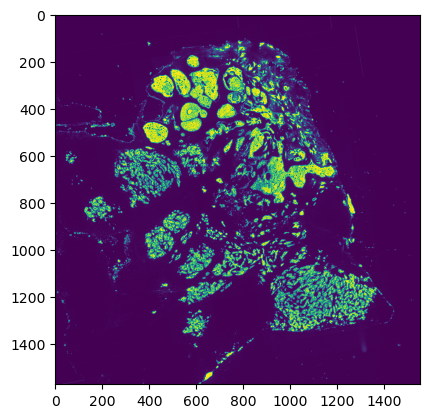

In [12]:
plt.imshow(thumbnail[channels.index('Pan-Cytokeratin')])

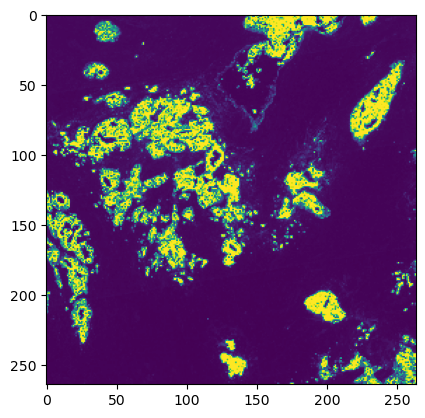

In [13]:
plt.imshow(thumbnail[channels.index('Pan-Cytokeratin'), 500:764, 500:764])

In [14]:
class MAETransform(object):
    def __init__(self, size=(256, 256), normalize=None):
        self.transforms = Compose([
            RandomCrop(size, padding_mode='reflect'),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            normalize if normalize is not None else nn.Identity()
        ])

    def __call__(self, x):
        return self.transforms(x)
    
class InferenceTransform(object):
    def __init__(self, normalize=None):
        self.transforms = Compose([
            normalize if normalize is not None else nn.Identity()
        ])

    def __call__(self, x):
        return self.transforms(x)
    
class SlideDataset(Dataset):
    def __init__(self, slide_to_img, transform=None):
        self.slides = sorted(slide_to_img.keys())
        self.slide_to_img = slide_to_img

        self.transform = transform if transform is not None else nn.Identity()

    def __len__(self):
        return np.iinfo(np.int64).max # make infinite

    def __getitem__(self, idx):
        slide = np.random.choice(self.slides)
        idx = self.slides.index(slide)
        return {
            'slide_idx': idx,
            'img': transform(self.slide_to_img[slide])
        }

class InferenceSlideDataset(Dataset):
    def __init__(self, slide_to_img, size=(256, 256), transform=None):
        """"""
        self.size = size
        self.slides = sorted(slide_to_img.keys())
        self.slide_to_img = slide_to_img
        
        # tiles are (ph pw c h w)
        self.slide_to_tiles = {s:self.to_tiles(x) for s, x in self.slide_to_img.items()}
        self.pw, self.ph = self.slide_to_tiles[self.slides[0]].shape[:2]
        
        self.n_tiles_per_image = self.pw * self.ph
        outs = torch.stack(torch.meshgrid(
            torch.arange(len(self.slides)),
            torch.arange(self.slide_to_tiles[self.slides[0]].shape[0]),
            torch.arange(self.slide_to_tiles[self.slides[0]].shape[1])
        ))
        self.idx_to_coord = rearrange(
            outs, 'b n_slides n_rows n_cols -> (n_slides n_rows n_cols) b',
            n_slides=len(self.slides), n_rows=self.ph, n_cols=self.pw, b=3)


        self.transform = transform if transform is not None else nn.Identity()
        
    def to_tiles(self, x):
        pad_h, pad_w = self.size[-2] - x.shape[-2] % self.size[-2], self.size[-1] - x.shape[-1] % self.size[-1]
        # left, top, right and bottom
        x = TF.pad(x, [pad_w // 2, pad_h // 2, pad_w // 2 + pad_w % 2, pad_h // 2 + pad_h % 2])
        x = x.unfold(-2, self.size[-2], self.size[-2] // 2)
        x = x.unfold(-2, self.size[-1], self.size[-1] // 2)
        x = rearrange(x, 'c ph pw h w -> ph pw c h w')
        return x

    def image_from_tiles(self, x):
        pad_h, pad_w = x.shape[-2] // 4, x.shape[-1] // 4
        x = x[..., pad_h:-pad_h, pad_w:-pad_w]
        return rearrange(x, 'ph pw c h w -> c (ph h) (pw w)')
    
    def slide_from_tiles(self, x, slide_idx):
        """
        x - (n c h w)
        """
        mask = self.idx_to_coord[:, 0]==slide_idx
        tiles = x[mask]
        ph, pw = self.idx_to_coord[mask, 1].max() + 1, self.idx_to_coord[mask, 2].max() + 1
        
        out = torch.zeros(ph, pw, x.shape[1], self.size[0], self.size[1])
        for idx, (_, r, c) in enumerate(self.idx_to_coord[mask]):
            out[r, c] = tiles[idx]
            
#         return out
        
        return self.image_from_tiles(out)

    def __len__(self):
        return self.idx_to_coord.shape[0]

    def __getitem__(self, idx):
        slide_idx, row_idx, col_idx = self.idx_to_coord[idx]
        slide = self.slides[slide_idx]
        return {
            'slide_idx': slide_idx,
            'row_idx': row_idx,
            'col_idx': col_idx,
            'img': transform(self.slide_to_tiles[slide][row_idx, col_idx])
        }

In [15]:
means = torch.cat([x.mean(dim=(-2, -1)).unsqueeze(0) for x in slide_to_img.values()]).mean(0)
stds = torch.cat([x.std(dim=(-2, -1)).unsqueeze(0) for x in slide_to_img.values()]).mean(0)
means, stds

(tensor([ 0.0801,  1.0852,  1.9242,  0.1526,  0.4242,  1.5283,  6.9707,  0.4142,
         10.0162,  3.5788,  0.2126, 11.7128,  5.6175,  6.0933,  0.1766,  1.1214,
          4.9701,  2.3110,  6.1405, 19.0076,  0.4349,  4.8628, 21.0575,  0.6115]),
 tensor([ 0.8096,  6.8269,  4.6411,  0.6164,  2.7208, 11.1956, 24.7025,  1.5357,
         13.1523, 10.1505,  1.7475, 36.9418, 14.6443, 21.0886,  0.8051, 10.7819,
          9.9388,  5.4503, 13.5437, 52.9554,  1.8941, 21.8240, 44.8913,  1.7298]))

In [16]:
size = (256, 256)

normalize = Normalize(means, stds)
transform = MAETransform(normalize=normalize)
ds = SlideDataset(slide_to_img, transform=transform)

In [17]:
d = ds[0]
tile = d['img']
slide_idx = d['slide_idx']
slide_idx

3

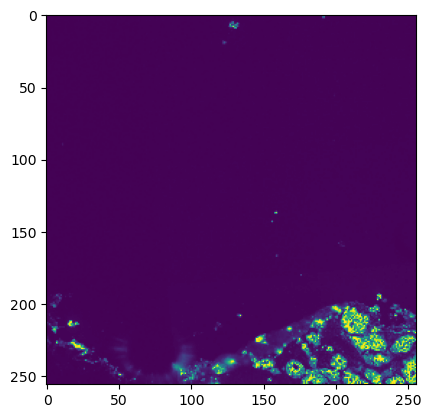

In [18]:
plt.imshow(tile[channels.index('Pan-Cytokeratin')])

In [19]:
dl = DataLoader(ds, batch_size=64, num_workers=10)

In [20]:
v = ViT(
    image_size = size[0],
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
    channels=len(channels),
)

In [21]:
mae = SlideMAEV2(
    encoder = v,
    n_slides = len(slide_to_img),
    decoder_dim = 512,      # paper showed good results with just 512
    decoder_depth = 6       # anywhere from 1 to 8
)

In [22]:
b = next(iter(dl))

In [23]:
recon_loss, pred_pixel_values = mae(b['img'], b['slide_idx'])
recon_loss

tensor(2.1789, grad_fn=<MseLossBackward0>)

In [24]:
pred_pixel_values.shape

torch.Size([64, 64, 24576])

In [25]:
from einops import rearrange

In [26]:
pred_patches = rearrange(
    pred_pixel_values, 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
    h=size[0] // 32, w=size[0] // 32, p1=32, p2=32, c=len(channels))
pred_patches.shape

torch.Size([64, 24, 256, 256])

In [27]:
# mae = SlideMAE(
#     encoder = v,
#     n_slides = len(slide_to_img),
#     masking_ratio = 0.25,   # the paper recommended 75% masked patches
#     decoder_dim = 512,      # paper showed good results with just 512
#     decoder_depth = 6       # anywhere from 1 to 8
# )

In [28]:
v = v.cuda()
mae = mae.cuda()

In [29]:
iters = 50000
lr = 1e-4
opt = torch.optim.Adam(mae.parameters(), lr=lr)

In [30]:
!mkdir -p ../data/mae_v4

In [31]:
channel_idx = channels.index('Pan-Cytokeratin')
channel_idx

19

0 tensor(2.1915, device='cuda:0', grad_fn=<MseLossBackward0>)


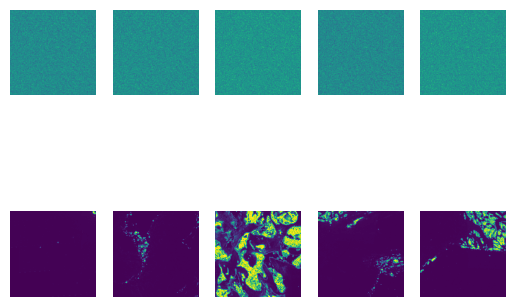

1000 tensor(0.7812, device='cuda:0', grad_fn=<MseLossBackward0>)


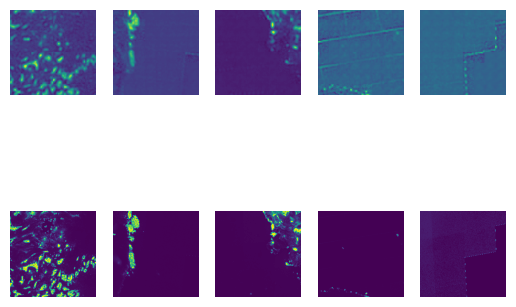

2000 tensor(0.8966, device='cuda:0', grad_fn=<MseLossBackward0>)


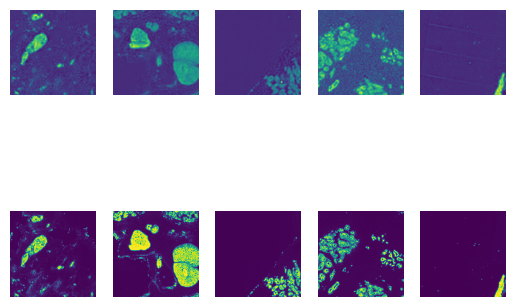

3000 tensor(0.7727, device='cuda:0', grad_fn=<MseLossBackward0>)


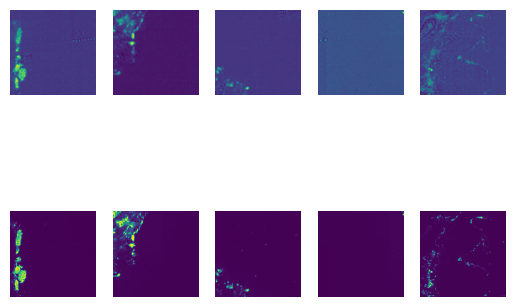

4000 tensor(0.8203, device='cuda:0', grad_fn=<MseLossBackward0>)


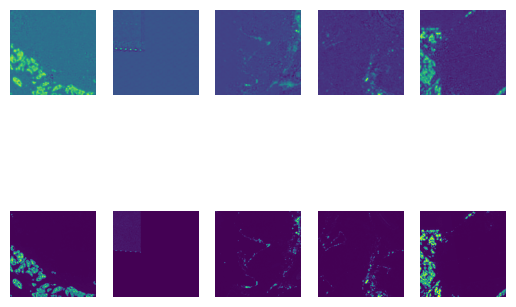

5000 tensor(0.7301, device='cuda:0', grad_fn=<MseLossBackward0>)


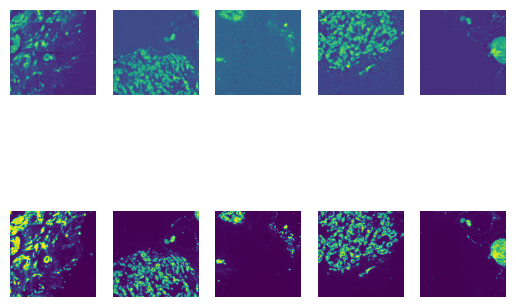

6000 tensor(0.7924, device='cuda:0', grad_fn=<MseLossBackward0>)


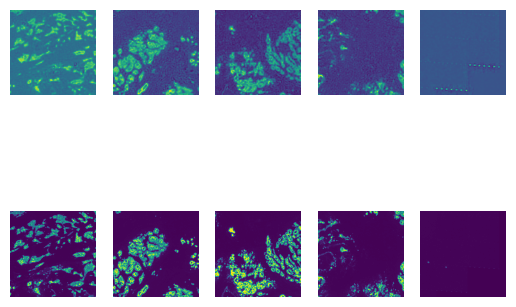

7000 tensor(0.8699, device='cuda:0', grad_fn=<MseLossBackward0>)


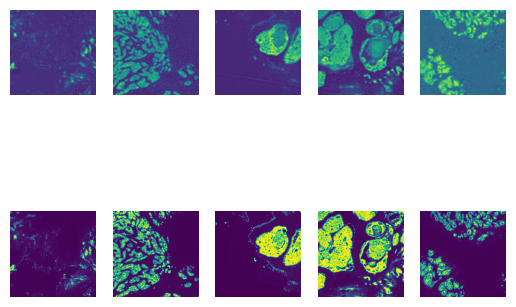

8000 tensor(0.8463, device='cuda:0', grad_fn=<MseLossBackward0>)


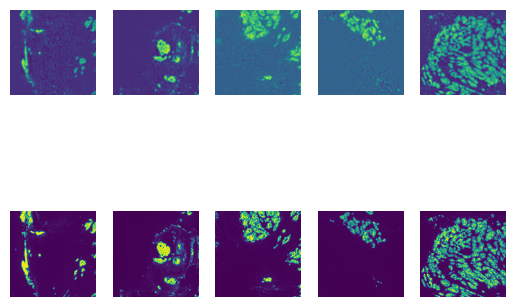

9000 tensor(0.7950, device='cuda:0', grad_fn=<MseLossBackward0>)


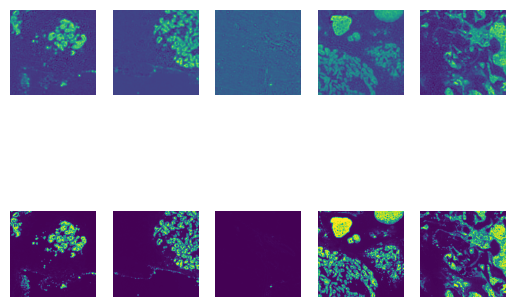

10000 tensor(0.7150, device='cuda:0', grad_fn=<MseLossBackward0>)


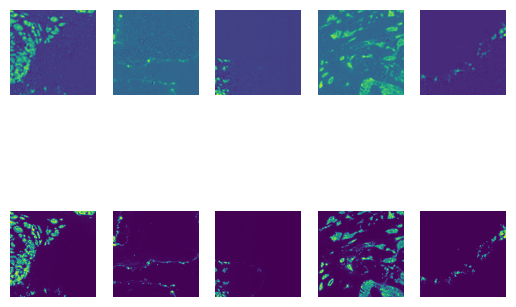

11000 tensor(0.7184, device='cuda:0', grad_fn=<MseLossBackward0>)


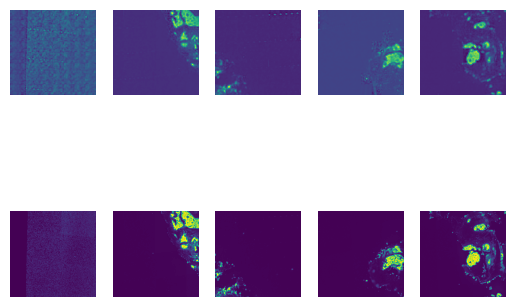

12000 tensor(0.7410, device='cuda:0', grad_fn=<MseLossBackward0>)


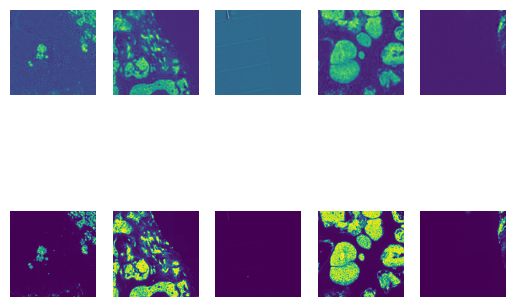

13000 tensor(0.8109, device='cuda:0', grad_fn=<MseLossBackward0>)


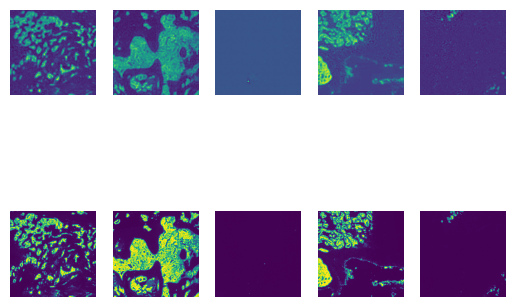

14000 tensor(0.7440, device='cuda:0', grad_fn=<MseLossBackward0>)


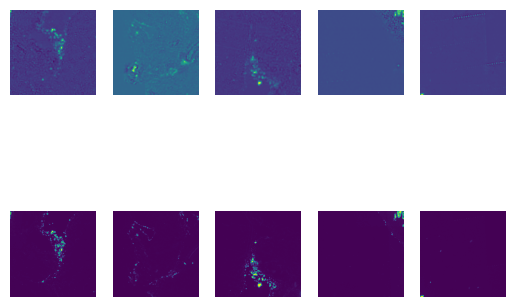

15000 tensor(0.8358, device='cuda:0', grad_fn=<MseLossBackward0>)


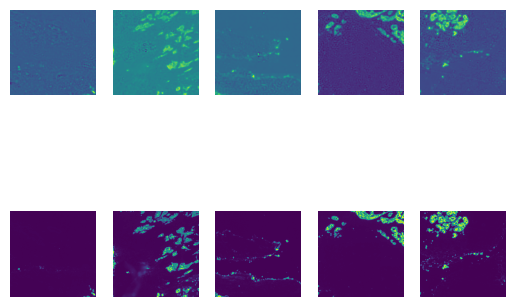

16000 tensor(0.7841, device='cuda:0', grad_fn=<MseLossBackward0>)


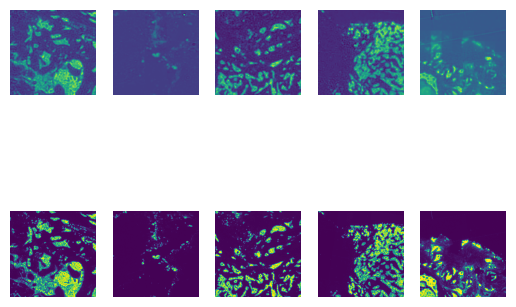

17000 tensor(0.8374, device='cuda:0', grad_fn=<MseLossBackward0>)


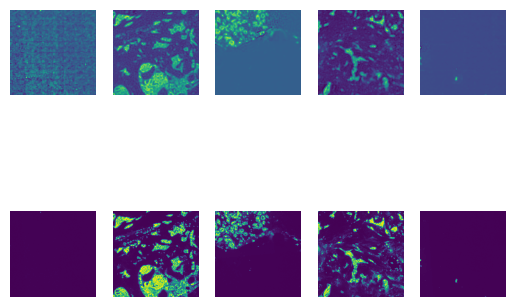

18000 tensor(0.8333, device='cuda:0', grad_fn=<MseLossBackward0>)


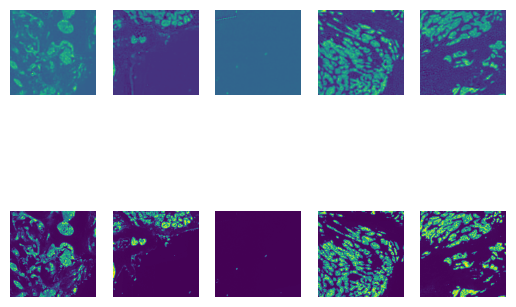

19000 tensor(0.6847, device='cuda:0', grad_fn=<MseLossBackward0>)


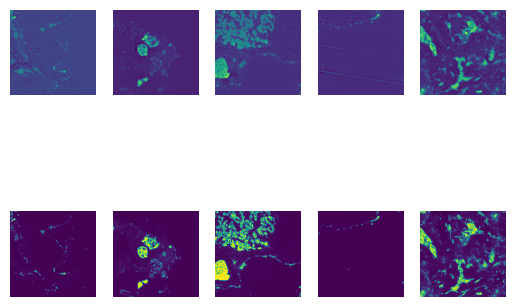

20000 tensor(0.8916, device='cuda:0', grad_fn=<MseLossBackward0>)


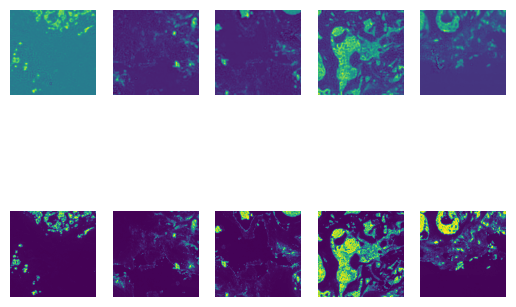

21000 tensor(0.8255, device='cuda:0', grad_fn=<MseLossBackward0>)


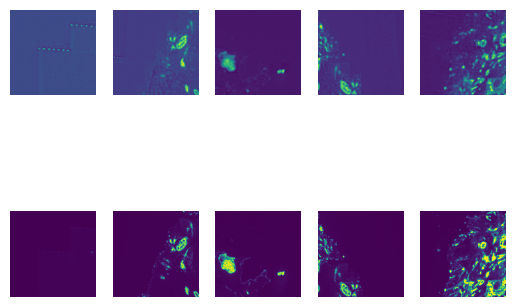

22000 tensor(0.7074, device='cuda:0', grad_fn=<MseLossBackward0>)


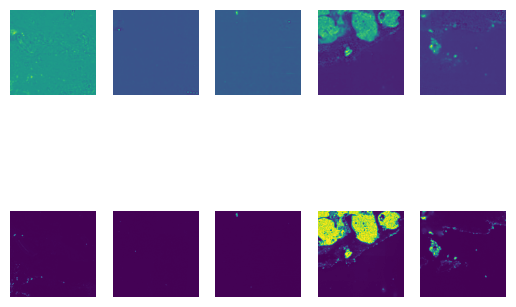

23000 tensor(0.8438, device='cuda:0', grad_fn=<MseLossBackward0>)


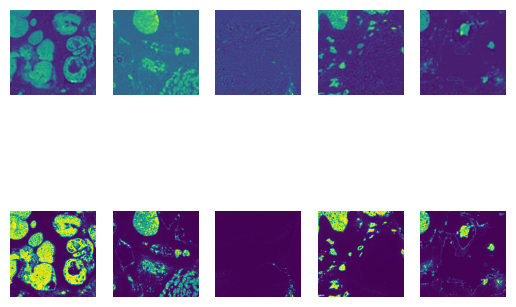

24000 tensor(0.9226, device='cuda:0', grad_fn=<MseLossBackward0>)


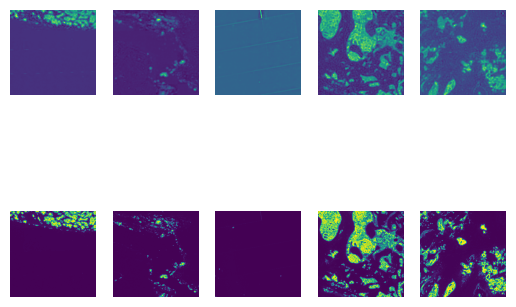

25000 tensor(0.8313, device='cuda:0', grad_fn=<MseLossBackward0>)


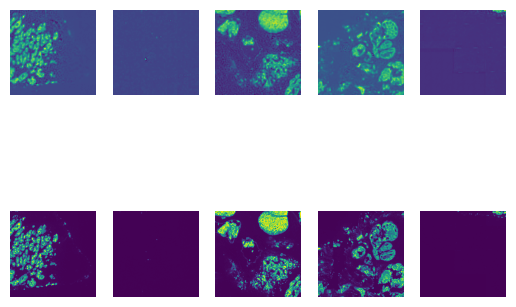

26000 tensor(0.8645, device='cuda:0', grad_fn=<MseLossBackward0>)


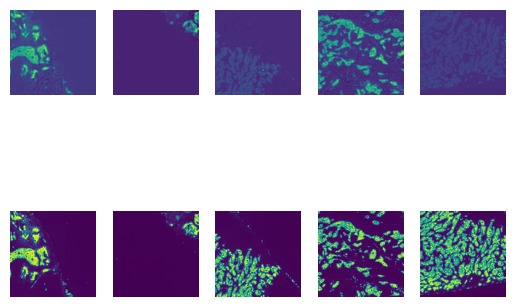

27000 tensor(0.9363, device='cuda:0', grad_fn=<MseLossBackward0>)


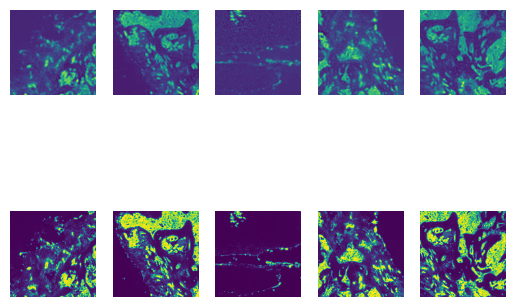

28000 tensor(0.7304, device='cuda:0', grad_fn=<MseLossBackward0>)


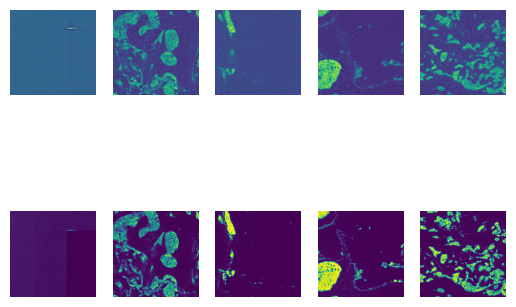

29000 tensor(0.8013, device='cuda:0', grad_fn=<MseLossBackward0>)


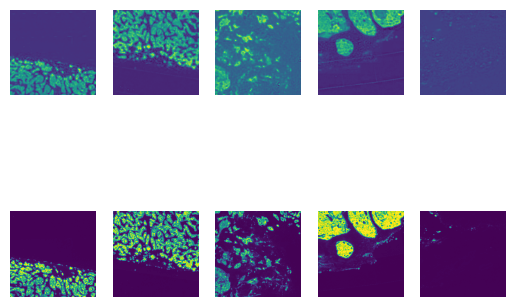

30000 tensor(0.7580, device='cuda:0', grad_fn=<MseLossBackward0>)


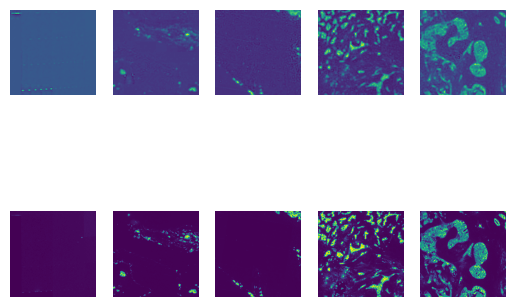

31000 tensor(0.7530, device='cuda:0', grad_fn=<MseLossBackward0>)


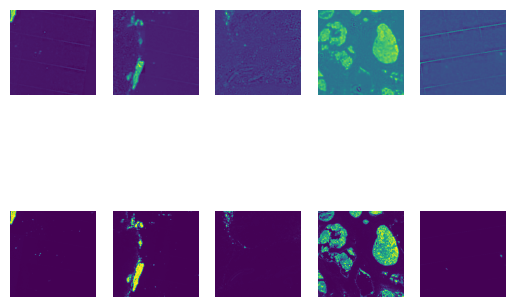

32000 tensor(0.8417, device='cuda:0', grad_fn=<MseLossBackward0>)


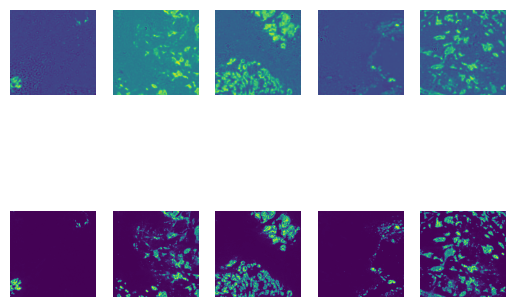

33000 tensor(0.7962, device='cuda:0', grad_fn=<MseLossBackward0>)


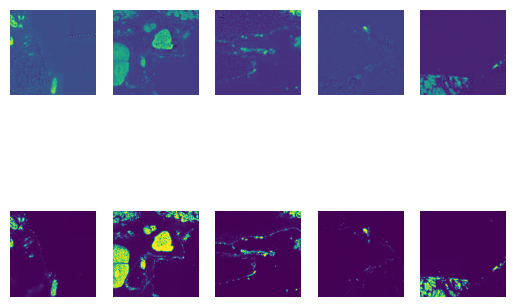

34000 tensor(0.7108, device='cuda:0', grad_fn=<MseLossBackward0>)


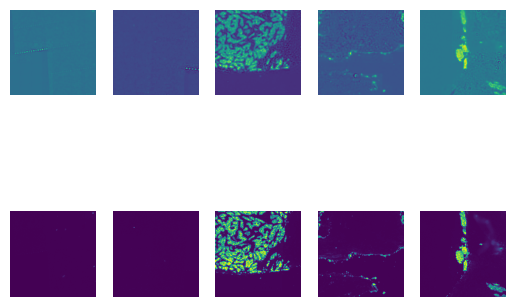

35000 tensor(0.8190, device='cuda:0', grad_fn=<MseLossBackward0>)


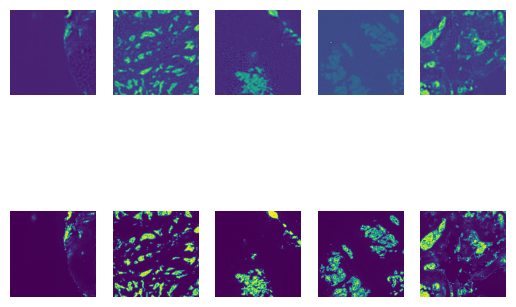

36000 tensor(0.8621, device='cuda:0', grad_fn=<MseLossBackward0>)


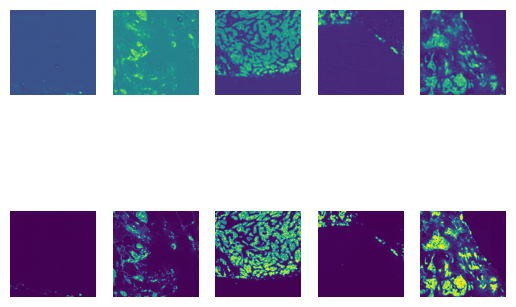

37000 tensor(0.7421, device='cuda:0', grad_fn=<MseLossBackward0>)


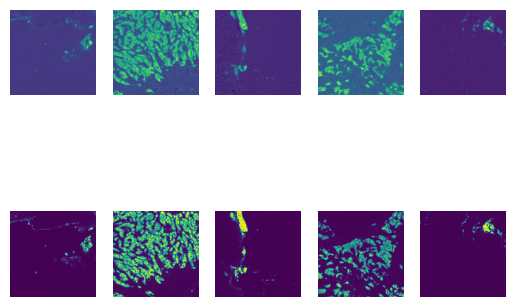

38000 tensor(0.8329, device='cuda:0', grad_fn=<MseLossBackward0>)


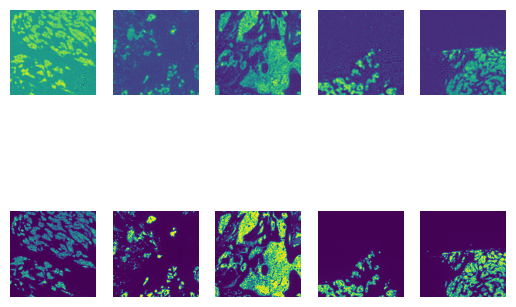

39000 tensor(0.7520, device='cuda:0', grad_fn=<MseLossBackward0>)


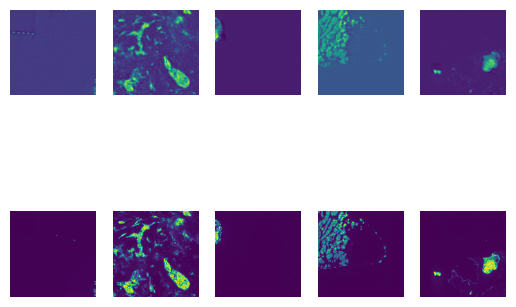

40000 tensor(0.7555, device='cuda:0', grad_fn=<MseLossBackward0>)


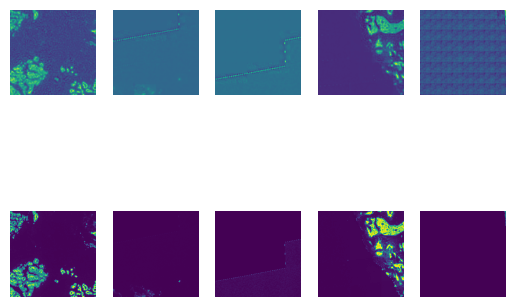

41000 tensor(0.7444, device='cuda:0', grad_fn=<MseLossBackward0>)


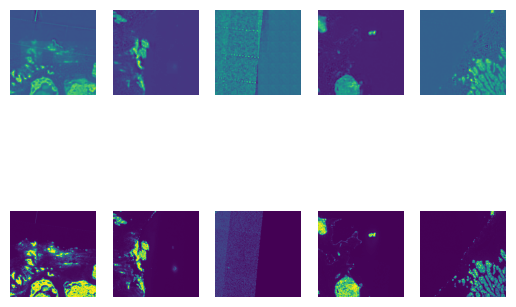

42000 tensor(0.7789, device='cuda:0', grad_fn=<MseLossBackward0>)


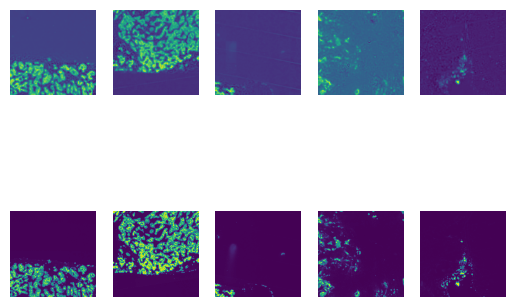

43000 tensor(0.8076, device='cuda:0', grad_fn=<MseLossBackward0>)


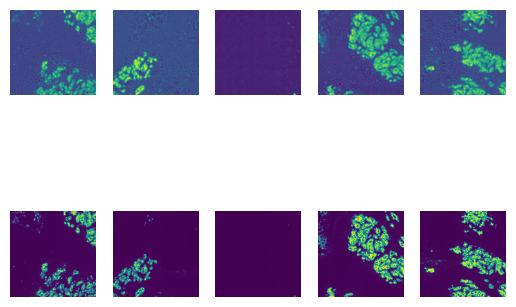

44000 tensor(0.7897, device='cuda:0', grad_fn=<MseLossBackward0>)


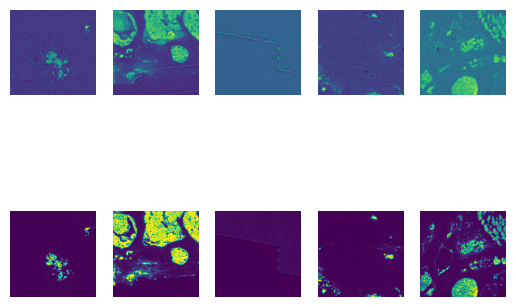

45000 tensor(0.7608, device='cuda:0', grad_fn=<MseLossBackward0>)


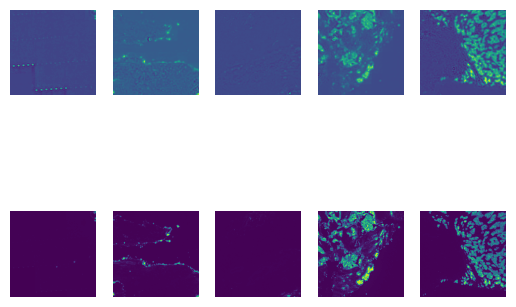

46000 tensor(0.6913, device='cuda:0', grad_fn=<MseLossBackward0>)


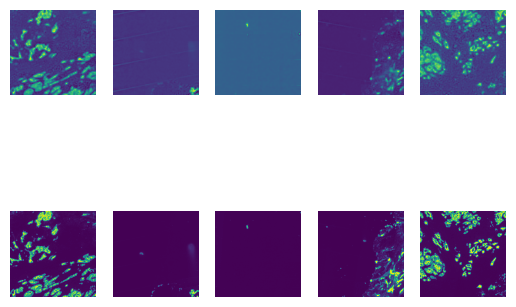

47000 tensor(0.8738, device='cuda:0', grad_fn=<MseLossBackward0>)


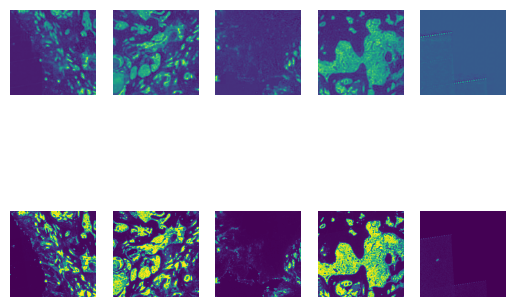

48000 tensor(0.9339, device='cuda:0', grad_fn=<MseLossBackward0>)


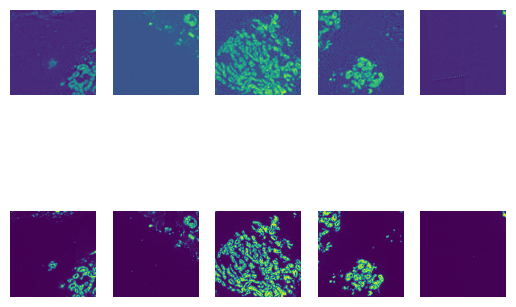

49000 tensor(0.9163, device='cuda:0', grad_fn=<MseLossBackward0>)


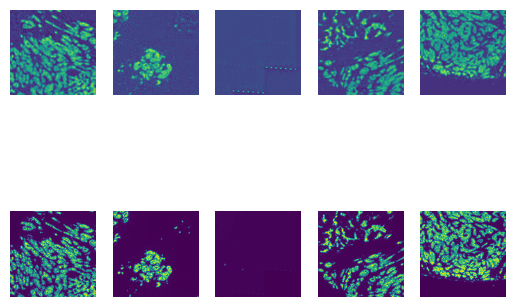

50000 tensor(0.8846, device='cuda:0', grad_fn=<MseLossBackward0>)


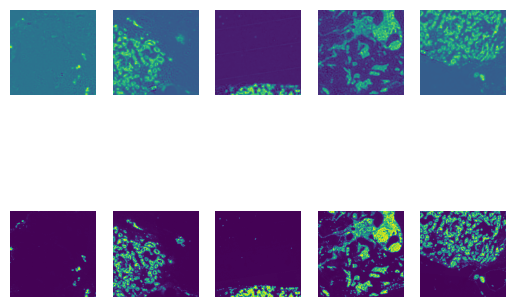

In [32]:
for i, b in enumerate(dl):
    opt.zero_grad()
    
    slide_idxs, imgs = b['slide_idx'], b['img']
    slide_idxs, imgs = slide_idxs.cuda(), imgs.cuda()
    loss, pred_pixel_values = mae(imgs, slide_idxs)
    loss.backward()
    opt.step()
    
    if i % 1000 == 0:
        print(i, loss)
        
        pred_patches = rearrange(
            pred_pixel_values, 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
            h=size[0] // 32, w=size[0] // 32, p1=32, p2=32, c=len(channels))
        
        fig, axs = plt.subplots(nrows=2, ncols=5)
        for c in range(axs.shape[1]):
            ax1, ax2 = axs[:, c]
            ax1.imshow(pred_patches[c, channel_idx].cpu().detach())
            ax1.axis('off')
            ax2.imshow(imgs[c, channel_idx].cpu().detach())
            ax2.axis('off')
            if c==0:
                ax1.set_ylabel('pred')
                ax2.set_ylabel('true')
        plt.show()
            
        
    if i % 1000 == 0:
#         torch.save(v.state_dict(), f'../data/mae_v4/{i}iter.pt')
        torch.save(mae.state_dict(), f'../data/mae_v4/{i}iter.pt')
        
    if i == iters:
        break

In [61]:
# torch.save(v.state_dict(), f'../data/mae_v3/1500iter.pt')

In [33]:
size = (256, 256)

normalize = Normalize(means, stds)
transform = InferenceTransform(normalize=normalize)
inference_ds = InferenceSlideDataset(slide_to_img, transform=transform)

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [34]:
inference_dl = DataLoader(inference_ds, batch_size=32, shuffle=False)

In [35]:
x = inference_ds.image_from_tiles(inference_ds.slide_to_tiles[inference_ds.slides[0]])
x.shape

torch.Size([24, 1664, 1664])

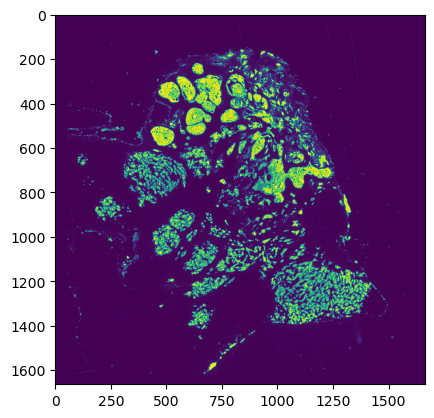

In [36]:
plt.imshow(x[channels.index('Pan-Cytokeratin')])

In [42]:
v = ViT(
    image_size = size[0],
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
    channels=len(channels),
)

In [43]:
# v.load_state_dict(torch.load('../data/mae_v4/46000iter.pt'))
# v.eval()

In [44]:
mae = SlideMAEV2(
    encoder = v,
    n_slides = len(slide_to_img),
    decoder_dim = 512,      # paper showed good results with just 512
    decoder_depth = 6       # anywhere from 1 to 8
)

In [45]:
mae.load_state_dict(torch.load('../data/mae_v4/46000iter.pt'))

<All keys matched successfully>

In [46]:
mae.eval()

SlideMAEV2(
  (encoder): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
      (1): LayerNorm((24576,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=24576, out_features=1024, bias=True)
      (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (transformer): Transformer(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (attend): Softmax(dim=-1)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_qkv): Linear(in_features=1024, out_features=1536, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=512, out_features=1024, bias=True)
                (1): Dropout(p=0.0, inplace=False)
              )
            )
          )
          (1

In [47]:
all_encoded_tokens = torch.zeros(len(inference_ds), size[0] // 32, size[1] // 32, v.pos_embedding.shape[-1])
all_decoded_tokens = torch.zeros(len(inference_ds), size[0] // 32, size[1] // 32, mae.decoder_dim)
all_pred_patches = torch.zeros(len(inference_ds), len(channels), size[0], size[1])
bs = inference_dl.batch_size
with torch.no_grad():
    for i, b in enumerate(inference_dl):
        x, slide_idx = b['img'], b['slide_idx']
        if v.pos_embedding.is_cuda:
            x, slide_idx = x.to(v.pos_embedding.device), slide_idx.to(v.pos_embedding.device)
        
        encoded_tokens = mae.encode(x, slide_idx)
        decoded_tokens = mae.decode(encoded_tokens)
        pred_pixel_values = mae.to_pixels(decoded_tokens[:, 1:])

        encoded_tokens = rearrange(encoded_tokens[:, 1:], 'b (h w) d -> b h w d',
                                  h=size[0] // 32, w=size[1] // 32)
        decoded_tokens = rearrange(decoded_tokens[:, 1:], 'b (h w) d -> b h w d',
                                  h=size[0] // 32, w=size[1] // 32)
        pred_patches = rearrange(
            pred_pixel_values, 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
            h=size[0] // 32, w=size[0] // 32, p1=32, p2=32, c=len(channels))
        
        all_encoded_tokens[i * bs:(i + 1) * bs] = encoded_tokens.cpu().detach()
        all_decoded_tokens[i * bs:(i + 1) * bs] = decoded_tokens.cpu().detach()
        all_pred_patches[i * bs:(i + 1) * bs] = pred_patches.cpu().detach()

In [48]:
all_encoded_tokens.shape, all_decoded_tokens.shape, all_pred_patches.shape

(torch.Size([676, 8, 8, 1024]),
 torch.Size([676, 8, 8, 512]),
 torch.Size([676, 24, 256, 256]))

In [49]:
x = inference_ds.slide_from_tiles(all_pred_patches, 0)
x.shape

torch.Size([24, 1664, 1664])

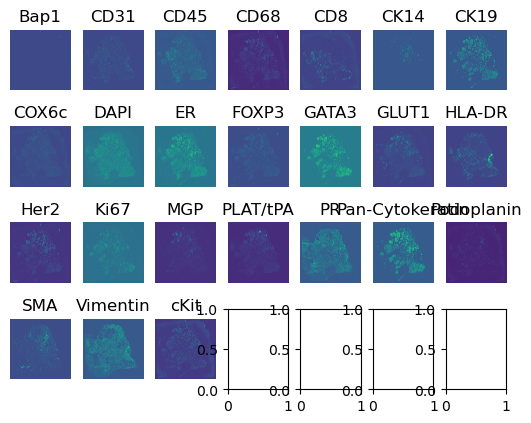

In [54]:
n_cols = 7
n_rows = len(channels) // n_cols + 1
rc = [(i, j) for i in range(n_rows) for j in range(n_cols)]

fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows)
rc = [(i, j) for i in range(n_rows) for j in range(n_cols)]
for (row_idx, col_idx), c in zip(rc, channels):
    ax = axs[row_idx, col_idx]
    ax.imshow(x[channels.index(c)])
    ax.axis('off')
    ax.set_title(c)